# Временные ряды 2. Преобразование признаков 

                                                    Сглаживай и разделяй 

Применение методов обучения к временным рядам требует прояснения нескольких моментов их настройки на задачу. Рассмотрим несколько примеров.

Пример 1. У нас игривый котенок. В течении дня он неоднократно играет по 5-10 минут, а после вечерней кормежки наш котенок всегда играет от 10 до 20 минут. Это значит, что сегодня после ужина он будет играть не менее 10 минут. Аналогичные условия вызывают аналогичные отклики. Это почти не зависит от размера  ужина, но довольно жестко связано со временем дня (или летом теплее, чем зимой и т.п.). Т.е. следующее явление ряда (играет или нет) можно предсказать опираясь на время кормежки и текущее время.

Пример 2. Когда бы мы ни пришли домой, наш растущий котенок выходит к нам, но сегодня спит. Это значит, что он не спал до этого? Это значит, что он съел нашу золотую рыбку и сыт? Это значит, что он маленький и устал? Однако от причины зависит наш выбор: срочно ехать к ветеринару или достать еще одну банку консервов. Узнать можно только если есть система видеонаблюдения, которая сохранила историю поведения объекта. Знание истории позволит принимать обоснованное решение.

Первый пример отличается от второго регулярным характером явления. Вернемся к нашим рядам: "Потребление энергии" и "Цена нефти BRENT". Будем использовать предобработанные версии этих рядов с признаками из календаря.   




## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [196]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [197]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [198]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

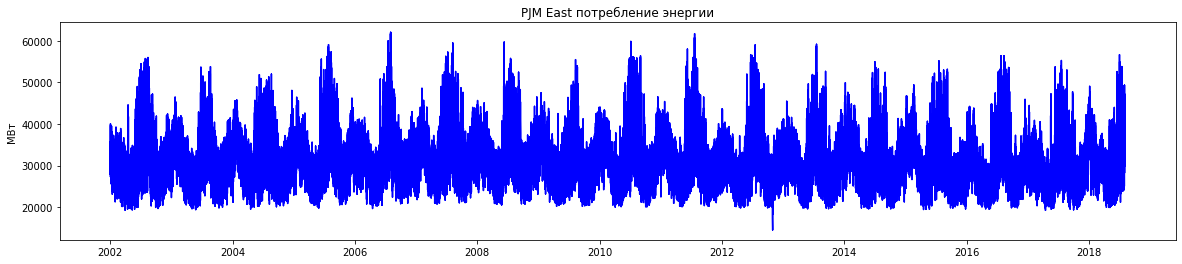

In [199]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

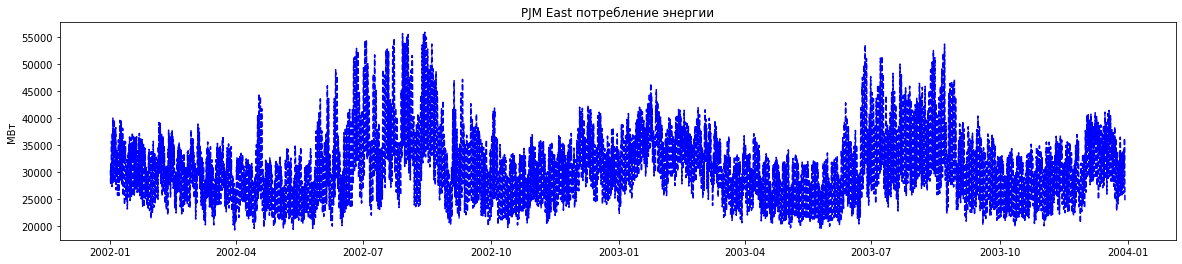

In [200]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [201]:

#path_brent = 'brent_cl_m5_20120101_20121231.csv'
#brent_data['Значение'] =brent_data['CLOSE']
#brent_data = pd.read_csv(path_brent,sep = ';', index_col=[0], parse_dates=[0])
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Основные статистики ряда остались без изменений.

In [202]:
brent_data.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

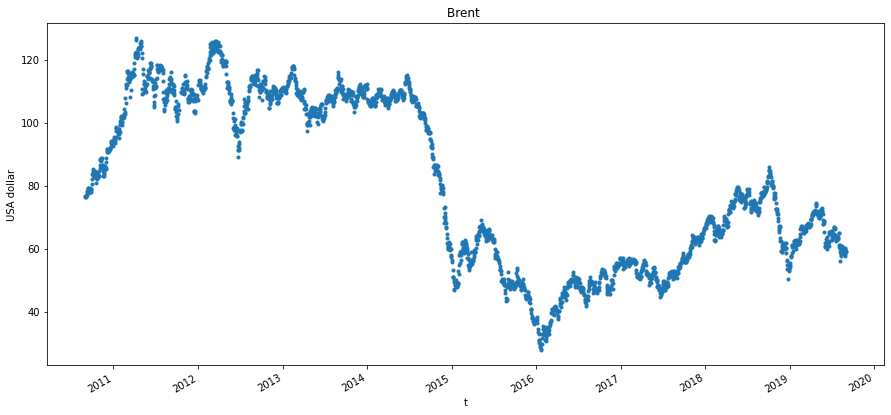

In [203]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Сравним два примера "Почасовое потребление энергии" и "Подневные цены на нефть":


Характер этих рядов существенно отличается. Энергия имеет выраженный порядок смены сезонов (рис.1) и дня и ночи (рис.2). Тогда как цена нефти не показывает никакой подобной динамики (Рис.3). Связать цены на нефть с календарем на этом этапе анализа не удалось. Это видно, по не очень впечатляющим результатам моделирования цены нефти (Временные ряды. часть 1).

В обеих последовательностях есть необычные артефакты: выброс 2012.10 в потреблении энергии и провал цены на нефть в 2014(природу которого нужно изучать).

Попробуем определить в чем основное различие между этими примерами.

### Стационарные и нестационарные временные ряды

При построении моделей временных рядов принято различать, в зависимости от наличия основной тенденции, стационарные и нестационарные временные ряды. Использование в регрессионной модели нестационарных временных рядов может привести к фиктивным результатам или к построению так называемой «мнимой» или ложной регрессии (spurious regression).

Множество моделей временных состоит из следующих типов https://studfiles.net/preview/4201538/page:16/):
- а) стационарные временные ряды (которые используются, в основном, для описания поведения «случайных остатков»), 
- б) нестационарные временные ряды, которые являются суммой детерминированного тренда,  
- в) нестационарные временные ряды, имеющие стохастический тренд, который можно удалить последовательным дифференцированием ряда (т.е. путем перехода от ряда уровней к ряду разностей первого или более высокого порядка).
    
    Установить тип временного ряда можно на основе:

    - Визуальный анализ: смотрим на график ищем очевидные тенденции и сезонность.
    - Сводные статистические данные: проверить статистику по разным участкам ряда и найти серьезные различия (если они есть).
    - Проверки ряда статистическими тестами: специализированные тесты (https://studopedia.ru/8_66042_tema-opredelenie-vremennogo-ryada-kriterii-proverki-vremennogo-ryada-na-statsionarnost.html). Например Тест Дики-Фуллера и его варианты для различных форм ряда. 
    
*иллюстрация к типам нестационарности ряда в* https://www.pvsm.ru/python/253543

Попробуем определить характеристики наших рядов. Посмотрим на ресемплинг (перерасчет рядов в новые временные отрезки,  месячные для потребления энергии и по нефти).

In [204]:
data_m = data.resample('M').mean()
brent_data_m = brent_data.resample('M').mean()

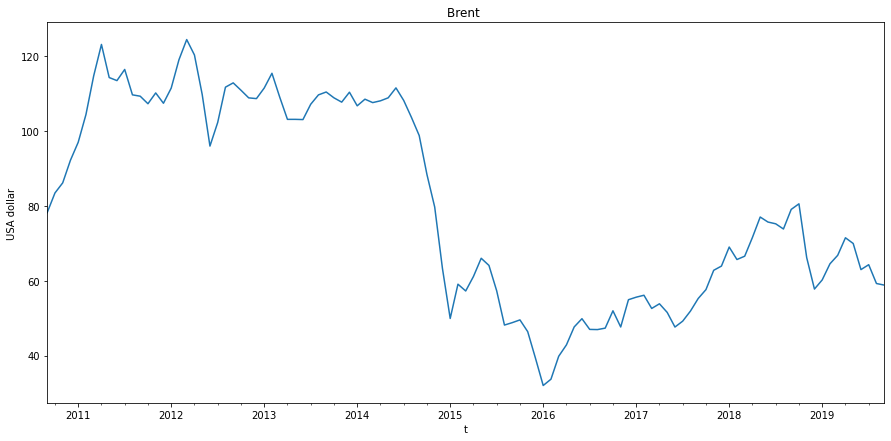

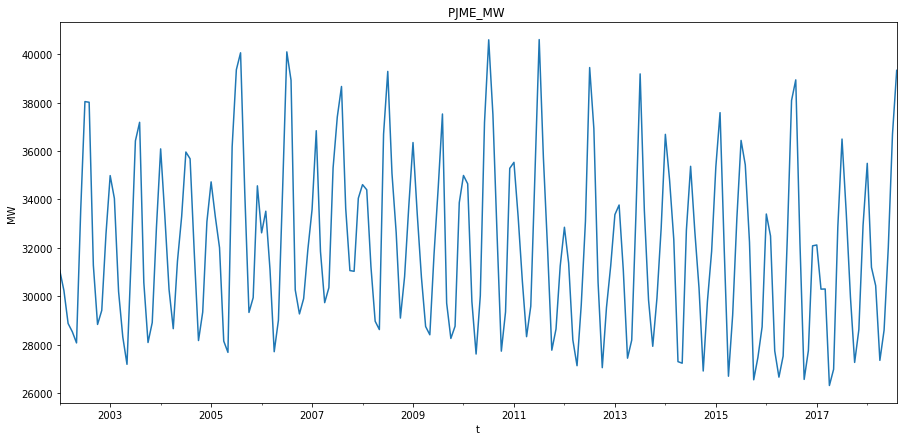

In [205]:
_ = brent_data_m['Значение'].plot( style='-', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.show()

_ = data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

Новые графики потеряли выбросы, но заметен различный характер рядов: сложное изменение для нефти и цикличность потребления энергии. Вывод ряд по потреблению энергии похож на стационарный, а нефть очень похожа на нестационарный. 

Посмотрим на годовые графики для потребления энергии и цен на нефть.

In [206]:
data_y = data.resample('Y').mean()
brent_data_y = brent_data.resample('Y').mean()

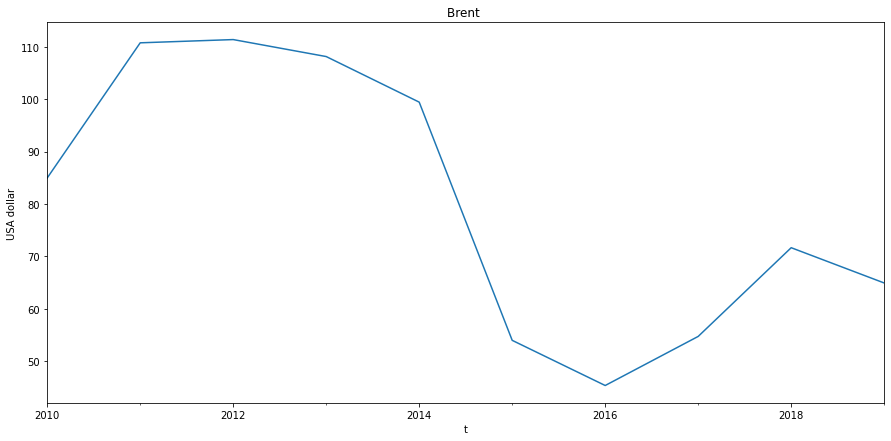

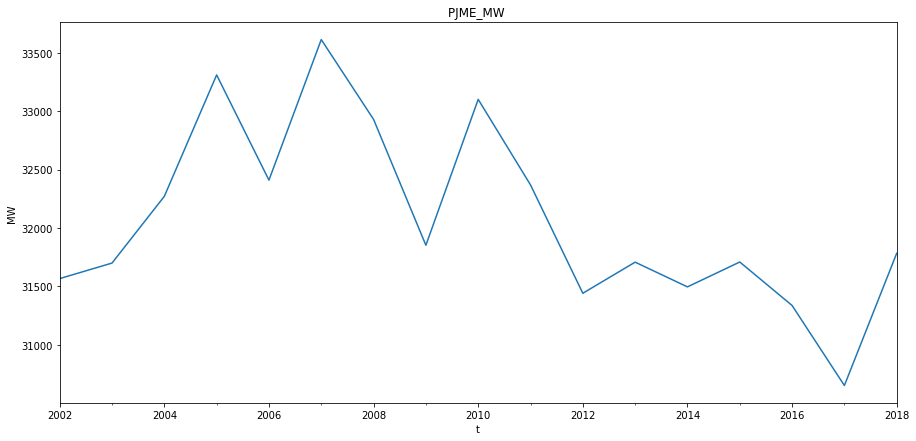

In [207]:
_ = brent_data_y['Значение'].plot( style='-', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.show()

_ = data_y['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

Оба графика напоминают случайное явление. Можно проверить как ведут себя первые разности (x(t)-x(t-1)). Если ряд таких разностей стационарен, то можно гарантировать стационарность ряда после удаления основной его части.

In [208]:
d_data = data[['PJME_MW']].diff()
d_brent_data = brent_data[['Значение']].diff()

In [209]:
data

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0


In [210]:
d_data

,PJME_MW
Date,
2002-01-01,NaN
2002-01-01,-1128.0
2002-01-01,-908.0
2002-01-01,-458.0
2002-01-01,158.0
...,...
2018-08-02,-1584.0
2018-08-02,-801.0
2018-08-02,-1704.0


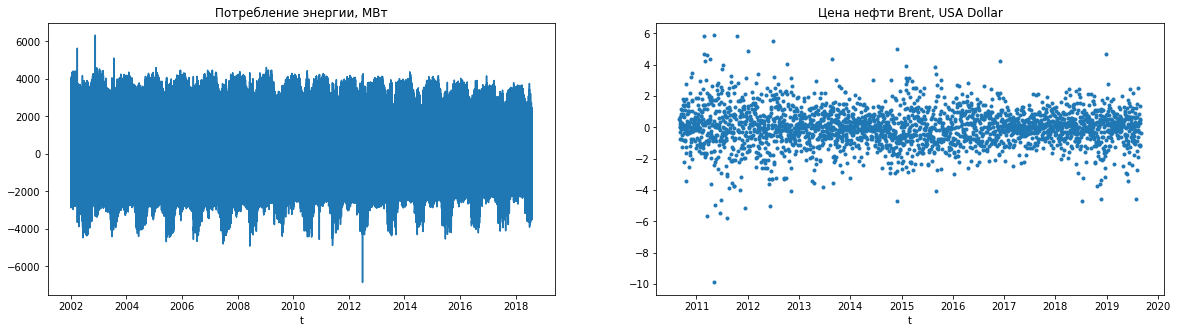

In [211]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(d_data.index,d_data['PJME_MW'])
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.subplot(1,2,2)
plt.plot(brent_data.index,d_brent_data['Значение'],'.')
plt.xlabel('t')
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

Для потребления энергии такая разность выглядит не совсем стационарно, а у нефти есть кардинальное изменение рассеивания во времени. Однако пока делать выводы рано.

Перестанем смотреть и попробуем применить компьютер. Определим значение Расширеного теста Дики-Фуллера(ADF) для наших рядов  Соответстующая функция доступна из https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html и позволит определить различные варианты применения теста. Импортируем модули из statsmodels и сделаем вызов теста ADF

In [212]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


Обращаемся к тесту с параметром regression='ctt' - анализировать на постоянные составляющие , линейные и квадратичные тренды.  Первый параметр должен содержать одномерный массив или Series

In [213]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values,regression='ctt')
DF_data

(-2.577455591729604,
 0.5247860093676766,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.9060995689206)

In [214]:
DF_brent = sm.tsa.stattools.adfuller(brent_data['Значение'].values, regression = 'ctt')
DF_brent

(-2.68221449579482,
 0.4644546682508199,
 1,
 2665,
 {'1%': -4.375483353680849,
  '5%': -3.8346077873672324,
  '10%': -3.554633956872604},
 8609.945844623533)

Ни нефть ни месячные средние по потреблению энергию не являются стационарными (у энергии явные сезоны). Проверим первые разности на стационарность.

In [215]:
DF_data_d = sm.tsa.stattools.adfuller(d_data['PJME_MW'].values[1:],regression='ctt')

DF_data_db = sm.tsa.stattools.adfuller(d_brent_data['Значение'].values[1:],regression='ctt')

print('коэффициент ADF для 1-й разности потребления энергии: p-value = ', DF_data_d[1])
print('коэффициент ADF для 1-й разности для цены нефти: p-value = ', DF_data_db[1])

коэффициент ADF для 1-й разности потребления энергии: p-value =  0.0
коэффициент ADF для 1-й разности для цены нефти: p-value =  0.0


Ряд $x_t$ называется TS-рядом, если существует некоторая детерминированная функция $f(t)$, такая что разность $x_{t}-f(t)$ является стационарным процессом. В частности, к TS-рядам относятся все стационарные ряды. Однако, многие TS-ряды являются нестационарными. 

Временной $X_{t}$ ряд называется интегрированным порядка k (обычно пишут $X_{t}\sim I(k)$), если разности ряда k-го порядка $\vartriangle ^{k}x_{t}$ — являются стационарными, в то время как разности меньшего порядка (включая нулевого порядка, то есть сам временной ряд) не являются TS-рядами. В частности I(0)-это стационарный процесс.

Получили 2 стационарных ряда, а на основании этого теста наши исходные ряды называют **интегрированным рядом** т.е. лаги изменение цены стационарны на дневных интервалах, а лаги изменения потребления энергии на часовых интервалах.

Это говорит о том, что нужно разделить модели на отдельные составляющие - сезонность у потребления энергии и тренд по месяцам у нефти отделим от стационарных колебаний вокруг этих компонент.

## Анализ результатов теста стационарности по Дики-Фуллеру

Первое значение кортежа ответа содержит показатель статистики теста.
Основное значение теста - второй элемент кортежа ответа: если он близок к нулю 0 (меньше чем 0.05)- ряд стационарен, иначе нет.
Третий параметр - длина временного отрезка (лага), который был использован при исследовании, а следующий за ним число рассмотренных точек ряда. Следующий по тексту ответа словарь содержит критические оценки по МакКинону для 1 % , 5 %, и 10 % вероятности отклонения гипотезы нестационарности ряда (Нулевая гипотеза теста — ряд не стационарен) (https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). 

Из результатов применения ADF следует:
ряд потребление энергии имеет значение DF_data[0] = -2.57  значительно больше критического для 10% (-3.57), а значит с вероятностью большей 10% не стационарен (Нуль-гипотеза отклонена). Он не имеет тренда, но есть сезоны.

Для ряда Brent:

- значение DF_brent[0] = -0.66 выше критических по всем вариантам и следовательно - ряд нестационарен.

- Поскольку разность 1-го порядка стационарный ряд, то это интегральный ряд. У ряда для разностей нет тренда.

Эти выводы подкрепляют наблюдения, которые мы сделали при рассматривании графиков. 

В случае ресемплинга Brent для месячных отсчетов - ряд ближе к стационарным (вероятность, что стационарный повысилась) . Поскольку измерений не очень много, то сделать ресемплинг на годовые метки можно, но не очень интересно (всего 8 лет наблюдений ).

Таким образом, у нас есть сезонный ряд - "потребление энергии" и нестационарный ряд - "цена Brent" (ну и растущий котенок, который, очевидно, имеет тренд и увеличивается в размерах). Модели предсказания стационарной и нестационарной составляющих разнличны и позволяют работать отдельно над представлением случайного и нет в наших временных рядах.


Попробуем перейти к стационарности для "цена нефти Brent" и выделить дневные и сезонные изменения , которые точно есть в "Потреблении энергии".

## Сглаживание


В отличии от операции пересчета примеров, где число измерений уменьшается, мы будем строить более интересные модели сглаживания. Это скользящие средние. Смысл такой средней состоит в том , что перевычисляется каждое значение ряда,т.е. временных меток останется ровно столько же. Как мы взвешивали котенка каждый день, чтобы узнать как он растет, так и будем взвешивать, но потом можем пересмотреть результаты с оценкой на несколько дней назад, т.к. вероятно были дни, когда котенок прибавил экстремально много, а иногда нет. Нам нужна история его роста, а не история его завтраков. Предсказывать скользящей средней следующее значение ряда сложно, т.к. это слишком примитивное решение в стиле "сегодня и завтра похожи", но можно выделить тренды нашего ряда. Тренд — основная тенденция изменения чего-либо https://av-finance.ru/texnicheskij-analiz/chto-takoe-trend.html.

Будем брать значение в точке с учетом предистории и текущее значение x(i) запишем как усредненную сумму n предшествующих (x(i-n) + x(n-i+1) + ...+ x(i)) * 1/(n + 1). Это пример простой скользящей средней. 

In [216]:
b_ar = brent_data['Значение'].values
b_s = pd.DataFrame(data = brent_data[['Значение']])

In [217]:
b_s.head()

,Значение
Дата,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63


In [218]:
N2 = 7
b_s['Значение'].rolling(window=N2).mean().head(10)

Дата
2010-09-01          NaN
2010-09-02          NaN
2010-09-03          NaN
2010-09-04          NaN
2010-09-05          NaN
2010-09-06          NaN
2010-09-07    76.744286
2010-09-08    76.967143
2010-09-09    77.012857
2010-09-10    77.275714
Name: Значение, dtype: float64

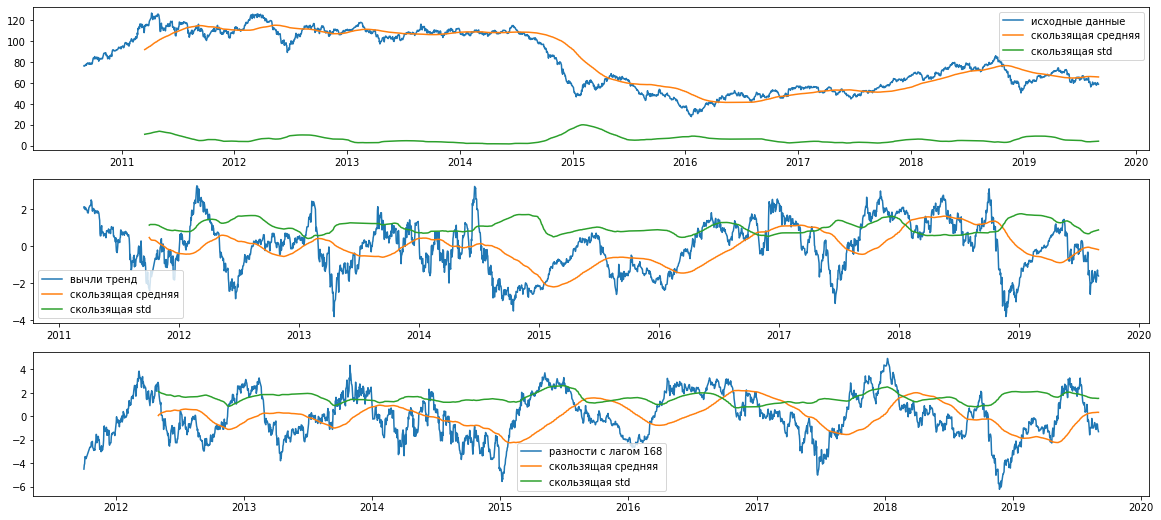

In [219]:
#import matplotlib.dates as mdates
# train = b_s.iloc[:-10, :]
# test = b_s.iloc[-10:, :]


N2 =24*7

b_s['z_data'] = (b_s['Значение'] - b_s['Значение'].rolling(window=N2).mean()) / b_s['Значение'].rolling(window=N2).std()
b_s['zp_data'] = b_s['z_data'].diff(N2)

def plot_rolling(b_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(b_s.index, b_s['Значение'], label='исходные данные')
    ax[0].plot(b_s['Значение'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s['Значение'].rolling(window=N2).std(), label="скользящая std");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом " +str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(b_s)    

Но это немного скучно. Давайте будем учитывать предшествующее значение с коэффициентом памяти, например вот так **(x(i)*a + (1-a)*(x(n-i+1)* a + (1-a)*( ...+ (1-a)*(x(i-n))))** - получим экспоненциальное сглаживание. Эти довольно длинно, но посмотрим на примере     

Text(0.5, 1.0, 'Brent 2010-2019')

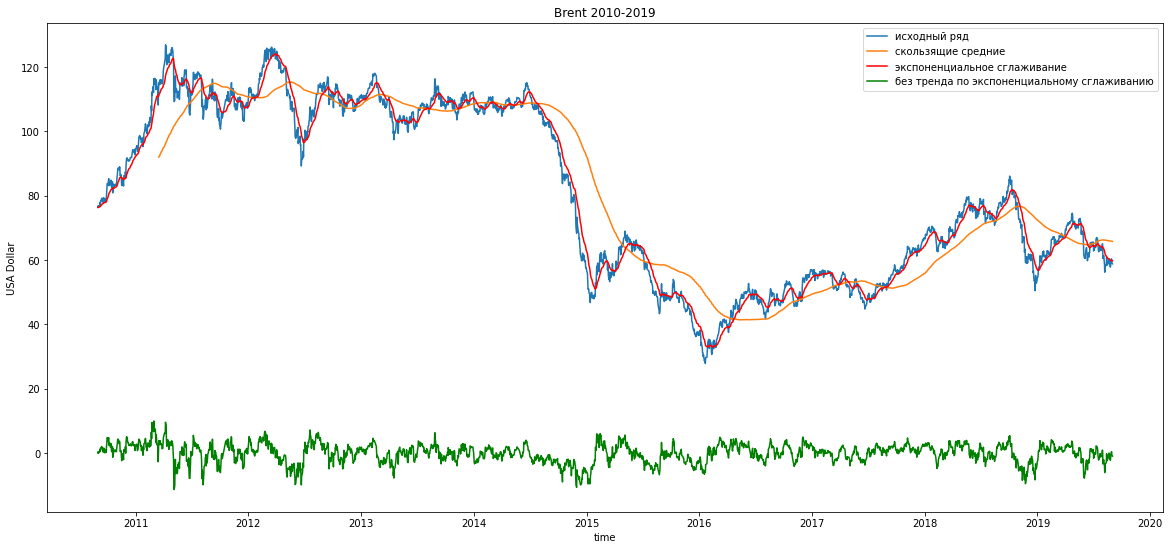

In [220]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

b_ar_exp_1 = exponential_smoothing(brent_data['Значение'], 0.08)

plt.figure(figsize=(20, 9))
plt.plot(b_s.index, b_s['Значение'], label='исходный ряд')
plt.plot(b_s['Значение'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(b_s.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(b_s.index,b_s['Значение'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('USA Dollar')
plt.legend()
plt.title('Brent 2010-2019')

In [221]:
b_s['exp'] = b_ar_exp_1

Результаты сглаживания по экспонентциальной модели заметно ближе и больше похожи на основное направление изменения нашей цены на нефть. Построим разницу между сглаженой и основной моделями цены на нефть. Проверим его на стационарность

In [222]:
b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = b_s.index)
#без тренда 
brent_data_trend_free = (b_s['Значение'] - b_ar_exp_1.iloc[:,0])
brent_data_trend_free.head()
DF_brent = sm.tsa.stattools.adfuller(brent_data_trend_free , regression = 'ctt')
print(f'p-value: {DF_brent[1]}')

p-value: 1.064095578224728e-14


В соответствии с тестом ADF - это стационарный ряд. Сгладим теперь и потребление энергии.


In [223]:
d_data=data.resample('D').mean()

Text(0.5, 1.0, 'PJME_MW')

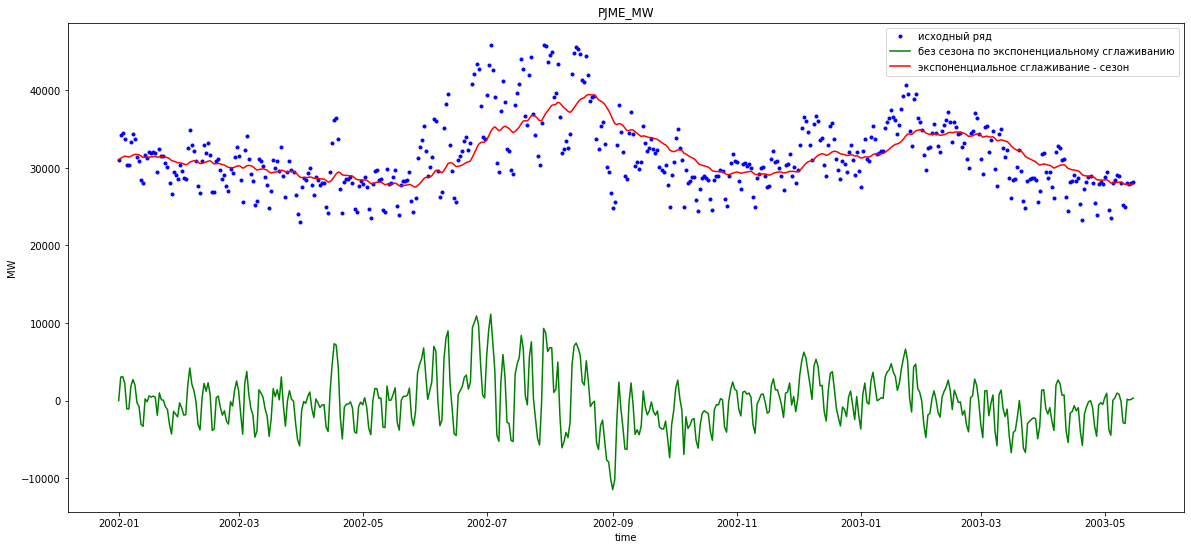

In [224]:

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', 
         label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание - сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [225]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1))\
                                       -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
print(f'p-value: {DF_[1]}')

p-value: 4.282974615351466e-11


Результат удаления явно сезонной составляющей для потребления энергии стационарный ряд.Перейдем к формированю пространства признаков, которое приблизит нас к цели - предсказанию следующего значения ряда.

## Этап Feature Engeniring
**Попробуем предсказать экспоненциальное сглаживание**

Добавим историю в наш ряд экспоненциального сглаживания для нефти брент. Основная информация временного ряда состоит в его предистории. Будем использовать различное число шагов предистории ряда и посмотрим как он будет реагировать на обработку такого представления. Это представление реализовано в Авторегрессионных моделях. В основу авторегрессионных моделей заложено предположение о том, что значение процесса линейно зависит от некоторого количества предыдущих значений того же процесса.

Посмотрим на модели, которые учитывают историю

AR - Авторегрессионная модель, которая является сравнительно простой и оперирует параметром: глубина регрессии - р. Соберем признаки для такой модели. В качестве признаков будем использовать измерения, которые делали в р предшествующие моменты времени. 

In [226]:
df= pd.DataFrame(b_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:,0].values-df.iloc[:-1,0].values


df.head()

/Users/murtazina/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Дата,,,,,,,,
2010-09-01,76.370000,0.000000,0.000000,0.0000,76.370000,76.370000,76.370000,0.000000
2010-09-02,76.411600,76.370000,0.000000,0.0000,76.370416,76.371248,76.373328,0.041600
2010-09-03,76.424272,76.411600,76.370000,0.0000,76.370955,76.372839,76.377404,0.012672
2010-09-04,76.439930,76.424272,76.411600,76.3700,76.371644,76.374851,76.382406,0.015658
2010-09-05,76.455136,76.439930,76.424272,76.4116,76.372479,76.377260,76.388224,0.015206


Text(0.5, 1.0, 'Облако корреляции')

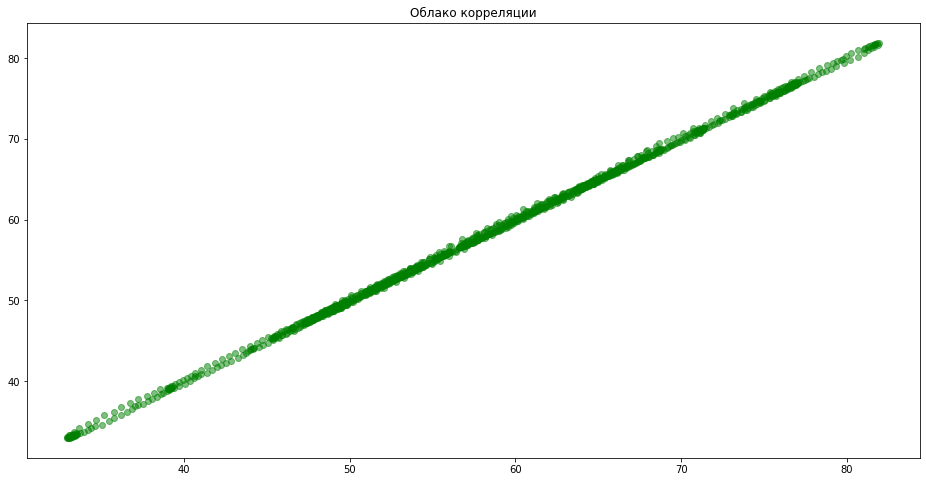

In [227]:
plt.figure(figsize = (16,8))
plt.scatter(df['2015-01-01':].iloc[1:,0], df['2015-01-01':].iloc[:-1,0].values, c="g", alpha=0.5)
plt.title('Облако корреляции')

In [228]:
df.columns

Index([0, 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08', 'diff1'], dtype='object')

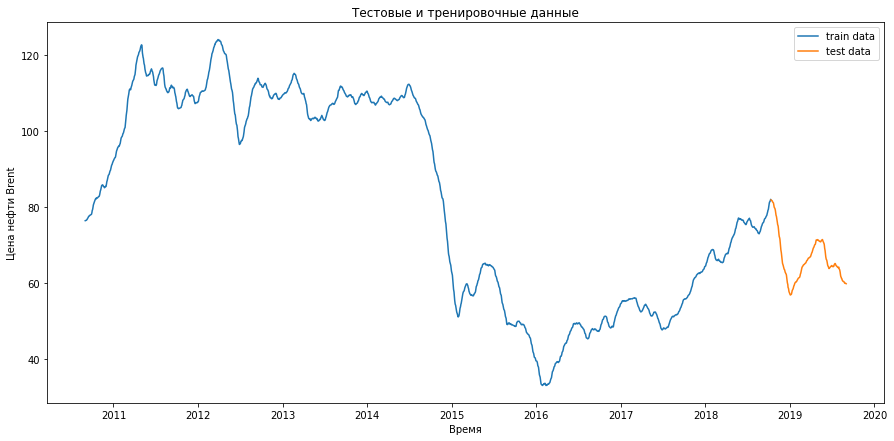

In [229]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Дата') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Дата') >  split_date].copy()
h= 1
train_b, test_b = split_data_b( df, '10-10-2018')

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index,train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index, test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

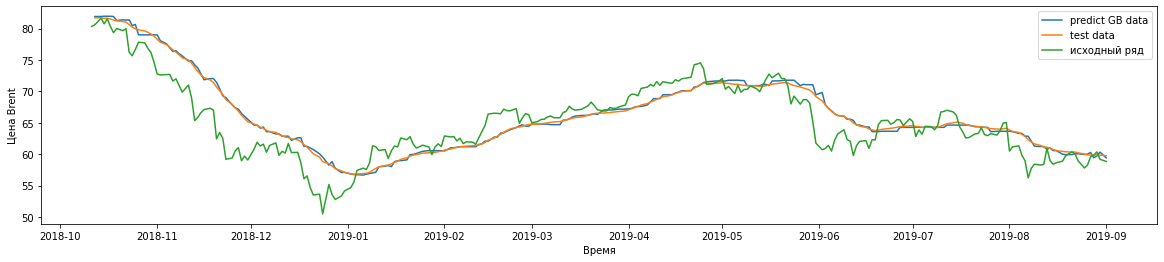

ошибка градиентного бустинга :   0.38346833688174536 %


In [230]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-10-11':].index, b_s.loc['2018-10-11':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Модель авторегрессии с горизонтом прогноза 1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.4%. Однако моделируем только нестационарный процесс и на коротком интервале прогноза. увеличим интервал прогноза до 10 шагов вперед. 

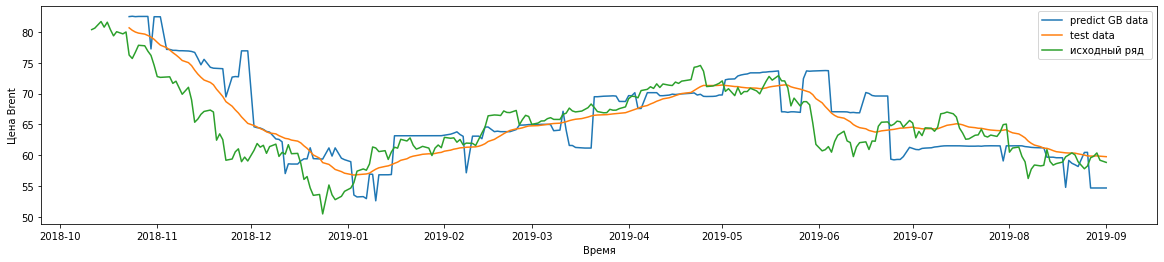

ошибка градиентного бустинга :   3.879463045861067 %


In [231]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-10-11':].index, b_s.loc['2018-10-11':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

 Очевидно, все стало не так хорошо (почти 4% ошибки по основной линии прогноза и много по реальному ряду)

Рассмотрим результаты моделирования. Исторические данные позволили повысить качество предсказания (было более 10% ошибки на одном шаге вперед), но пока не умеем определить прогноз для стохастической части наших данных. Кроме того, есть явное непонимание модели длинных периодов прогнозирования. Следующая проблема - сколь сильно следует сглаживать наш ряд и как выбрать параметры модели.   

Таким образом, разделение на стационарную и нестационарную части наших рядов дает:
- ОШИБКА ПРОГНОЗА УМЕНЬШИЛАСЬ,
- СТАЦИОНАРНУЮ ЧАСТЬ НЕ ОБЪЯСНЯЕМ ПОКА НИКАК,
- НУЖНО НАЙТИ ХОРОШИЙ НАБОР ИСТОРИЧЕСКИХ ДАННЫХ НАШЕГО РЯДА.

В следующей части обсудим задачу оценки параметров модели временного ряда и способов обработки стационарной части модели.

## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

2. Оцените ошибку модели из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени
    
5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)

Интересные ссылки:
1. Пакет стат.моделирования https://www.statsmodels.org/stable/
1. Пакет для прогнозирования во временных рядах от FaceBook https://facebook.github.io/prophet/docs/quick_start.html